## Demo

For this project, we will use the exact same tools we use in our Neural Network class, except for the Python Gym. The Gym is a module developed by the OpenAI, it lets us use game environments for training the reinforcement algorithm. The Gym supplies us with State (environment), rewards and actions for training our ANN. Particularly, We will be working with the Q-learning Algorithm. We will be using traning network for this demo and exclude the traning expect of since it take more than a day to complete the training, instead we will focus on how to run our train model.

In [1]:

# OpenAI Gym
import gym_tetris as gym
import gym.spaces
import numpy as np
import keras

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output
import cv2

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


Using TensorFlow backend.


Firstly, we note that the state given by 'observation' is a 3-tensor with 430x330 dimension and 3 for color. We will use this state as input and use a convolutional neural network to detect pieces in the screen, which renders us with millions of parameters making the network extremely slow and difficult to train. To resolve this, we will change transform it to grey image and downsize it to 10x20x3. 

In [2]:
env = gym.make('Tetris-v0')
downsize = (10,20)
observation=env.reset()

To downsize the observation, we use cv2 module. To make it undemanding, we have build this function that downsizes the observation.

In [3]:
def resize(img,downsize):
    resized = cv2.resize(img,
                         dsize=downsize,
                         interpolation=cv2.INTER_CUBIC)
    return resized

In [4]:
resized_observation = resize(observation[17:423,7:212],downsize)
in_size = resized_observation.shape
obs_size = resized_observation.size
action_space = 6
display(in_size)
display(obs_size)
display(action_space)

(20, 10, 3)

600

6

Finally, we will use convolutional neural network for our model. The input is (20, 10, 3) tensor which is the state of the game. Convolutional NN is best for this problem because Convolutional NN is optimal for detecting pieces. Our network follows a very conventional method which is convolution by 3x3 kernal, convolution, maxpool and dense. Then we use regular fully connected NN going from 64 to 20. This model outputs array of length 6. Output represents the Q values that we learned in the class. We will choose the maximum Q value for the action.

In [5]:
def make_model(state, action_size):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=(20, 10), activation='relu',
                                    input_shape=[state.shape[0],
                                                 state.shape[1],
                                                 state.shape[2]]))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(action_size, activation='linear'))
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001))
    return model

model = make_model(resize(observation,downsize), 
                   action_space)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1, 64)          38464     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 64)          4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1, 64)          4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 126       
Total para

One of the key aspect of the Q-learning is the Replay Memory. Replay Memory stores the state, action and the reward associated with that action. Firstly, we initialize the class ReplayMemory using __init__ function. We store state in the self.current_state array which is of the same dimension as our observation. Actions and rewards are stored in self.action and self.reward arrays respective.  

In [6]:
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = [state_size.shape[0], state_size.shape[1], state_size.shape[2]]
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size, 
                                       self.state_size[0], 
                                       self.state_size[1], 
                                       self.state_size[2]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size, 
                                    self.state_size[0], 
                                    self.state_size[1],
                                    self.state_size[2]])
        self.done = [False]*memory_size # Boolean (terminal transition?)
        
    def remember(self, current_state, action, reward, next_state, done):
    # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            model_targets = model.predict(current_state)
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model.predict(next_state),axis=1)

            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets

            # Update the weights accordingly
            model.fit(current_state,model_targets,epochs=1,verbose=0,batch_size=sample_size)

        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [7]:
from collections import deque

# Hyperparameters
gamma = 0.95
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.2
episodes = 30000


replay_iterations = 50
replay_sample_size = 1024

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)
rewards = deque(maxlen=episodes)
epsilons = deque(maxlen=episodes)
max_Qs = deque(maxlen=episodes)
min_Qs = deque(maxlen=episodes)
avg_Qs = deque(maxlen=episodes)

# Initialize the environment and agent data structures
env = gym.make('Tetris-v0')
observation = env.reset()
resized_obs = resize(observation[17:423,7:212],downsize)
model = make_model(resized_obs, action_space)
target_model = make_model(resized_obs, action_space)
memory = ReplayMemory(10000, resized_obs, action_space)

For this part of the code, you will need to download the weight from the our github website. https://github.com/CSCI4850/S19-team5-project/blob/master/weights.h5. 

In [8]:
model.load_weights('weights.h5')

Finally, we will run the model. We start by initaiting the gym. Observation give you the state of the game that we will feed into the network. We will let time and reward to equal to zero. We will have to resize the observation for each instance. plt.imsho yeilds the downsized state. Finally, we use the max Q value that we aquire from our model. Q value determines the action of the tetris. <br>

You can also uncomment the display(plt.gcf()) to watch the model play tetris in the real time. However, ther is a chance of getting display error which we do not know how to fix. 

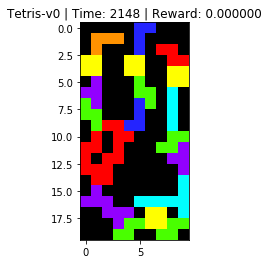

In [9]:
# Test out the agent!
# Initialize the environment and let the agent decide how to act!
env.close()
env = gym.make('Tetris-v0')
observation = env.reset()
done = False
time = 0
reward = 0.0
while not done:
    if not time%3:
        obs = resize(observation[17:423,7:212],downsize)
        plt.imshow(obs)
        plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
        clear_output(wait=True)
        Q = model.predict(np.expand_dims(obs,axis=0))
        action = np.argmax(Q)
        #display(plt.gcf())
        observation, reward, done, info = env.step(action)
        next_height=info['height']
        if (done):
            break
    else:
        action=0
        observation, reward, done, info = env.step(action)
    time+=1
clear_output(wait=True)